In [1]:
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats, signal
import matplotlib.pyplot as plt

 - https://www.wolframalpha.com/input?i=diff%5Br*C%5Ep%281-%28C%2FK%29%5Ea%29%2C+r%5D
 - https://www.wolframalpha.com/input?i=diff%5Br*C%5Ep%281-%28C%2FK%29%5Ea%29%2C+p%5D
 - https://www.wolframalpha.com/input?i=diff%5Br*C%5Ep%281-%28C%2FK%29%5Ea%29%2C+K%5D
 - https://www.wolframalpha.com/input?i=diff%5Br*C%5Ep%281-%28C%2FK%29%5Ea%29%2C+a%5D
 - https://www.wolframalpha.com/input?i=C%27%28t%29+%3D+r*C%5Ep%281-%28C%28t%29%2FK%29%5Ea%29

In [2]:
scale = 1e5

In [3]:
def GRM_ODE(t, C, r, p, K, a):
    return r*(np.power(C*scale, p)/scale)*(1-np.power(((C*scale)/(K*scale)), a))

In [4]:
def GRM(t, C0, r, p, K, a, rtol=1e-6):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C0], t_eval=t, args=(r, p, K, a), rtol=rtol).y[0]

In [5]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")
data["DATE"] = pd.to_datetime(data["DATE"])

In [6]:
cases = data.groupby("DATE")["CASES"].sum().to_frame()
cases["index"] = (cases.index - cases.index[0])//pd.Timedelta("1d")
cases["cumsum"] = cases["CASES"].cumsum()
cases = cases.reset_index().rename(columns={"CASES": "daily", "DATE": "date"}).set_index("date")
cases["cs_mv14d"] = cases["cumsum"].rolling(14).mean().shift(-7)
cases["d_mv14d"] = cases["cs_mv14d"].diff()
cases["cs_savgol"] = signal.savgol_filter(cases["cumsum"], 31, 7)
cases["d_savgol"] = cases["cs_savgol"].diff()
cases.to_csv("covid.csv", index=False)
cases.sample(10)

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol
date,,,,,,,
2020-06-14,22,105,60482,6.060714e+04,95.642857,6.055276e+04,84.295824
2022-02-15,11528,716,3478825,3.478495e+06,9765.357143,3.478795e+06,9480.876553
2021-02-11,2052,347,733798,7.343687e+05,1927.000000,7.332223e+05,1757.255036
2021-11-25,20231,634,1708560,1.712696e+06,17647.857143,1.703662e+06,17829.060705
2021-12-16,8110,655,1995647,1.994496e+06,8052.285714,1.994547e+06,7891.583621
2021-06-18,424,474,1075897,1.075831e+06,398.928571,1.075796e+06,361.598091
2021-11-28,7072,637,1747266,1.765063e+06,17381.000000,1.757989e+06,17891.602975
2020-08-07,771,159,74645,7.451179e+04,589.500000,7.429904e+04,634.655718
2021-09-23,2080,571,1226543,1.227048e+06,1950.285714,1.226144e+06,1928.626819


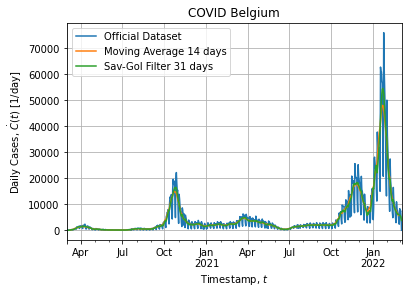

In [7]:
axe = cases["daily"].plot(label="Official Dataset")#, linestyle="none", marker=".", markersize=3)
cases["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

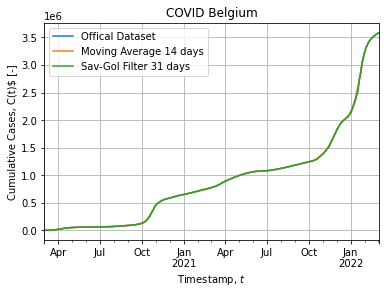

In [8]:
axe = cases["cumsum"].plot(label="Offical Dataset")
cases["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.set_yscale("linear")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, C(t)$ [-]")
axe.grid()

In [9]:
t0 = "2021-12-21"
t1 = "2022-02-21"

In [10]:
peak = cases.loc[(cases.index >= t0) & (cases.index < t1), :]
for k in ["index", "cumsum", "cs_mv14d", "cs_savgol"]:
    peak[k + "_origin"] = peak[k] - peak[k][0]
peak.sample(5)
peak.to_csv("peak.csv", index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


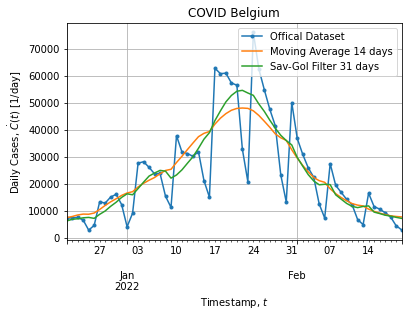

In [11]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset")
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

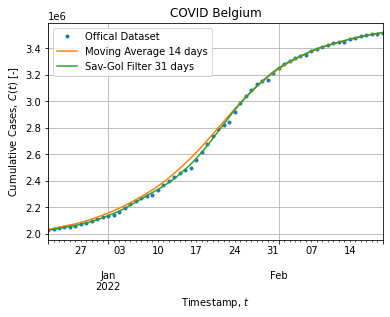

In [12]:
axe = peak["cumsum"].plot(marker=".", linestyle="none", label="Offical Dataset")
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, $C(t)$ [-]")
axe.grid()

In [13]:
peak.loc["2022-02-20", "cumsum"] - peak.loc["2021-12-21", "cumsum"]

1486374.0

In [14]:
def resample(frame):
    sample = frame.copy()
    # Reindex:
    sample = frame.set_index("index_origin")
    index = np.arange(sample.index.min(), sample.index.max() + 0.001, 0.25)
    sample = sample.reindex(index).interpolate().reset_index()
    # Resample:
    sample = sample.sample(frac=1.0, replace=True).sort_index()
    # Deduplicate + Counts:
    count = sample.groupby(sample.index)["index"].count()
    count.name = "count"
    sample = sample.drop_duplicates().merge(count, left_index=True, right_index=True)
    sample = sample.sort_index()
    sample["sigma"] = np.sqrt(1/sample["count"])
    return sample
r = resample(peak)
#r.set_index("index_origin")["cs_mv14d_origin"].plot()

In [15]:
np.random.seed(123456789)

In [16]:
params = pd.read_csv("bootstrap_sg_x4_200.csv")

In [17]:
params.sample(5)

,C,r,p,K,a
86,0.171232,2.335022,0.752591,14.860331,2.243961
118,0.222570,1.525334,0.787815,14.887170,1.987413
155,0.179406,2.072388,0.762390,14.887217,2.149280
83,0.176391,1.666754,0.781944,15.026415,1.910989
191,0.179626,1.874563,0.770707,14.874714,2.137730


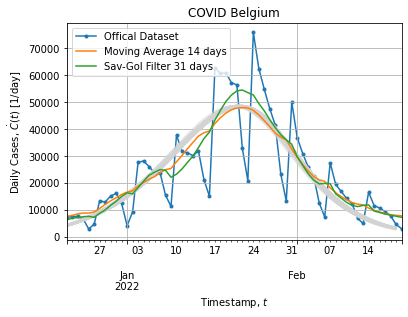

In [18]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=-22)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale
    axe.plot(peak.index[:-1], np.diff(c), color="lightgrey", linewidth=0.6)
#c = GRM(peak["index"], *popt)
#axe.plot(peak.index[:-1], np.diff(c), "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")#, zorder=-20)
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")#, zorder=-21)
axe.legend(loc="upper left")#bbox_to_anchor=(1,1), loc="upper left")
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

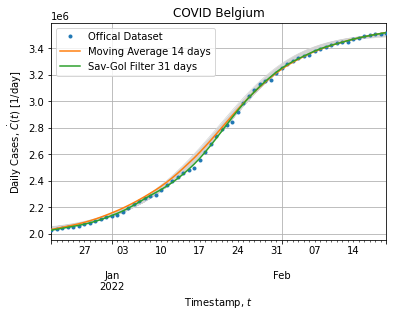

In [19]:
fig, axe = plt.subplots()
peak["cumsum"].plot(linestyle="none", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale + peak["cumsum"][0]
    axe.plot(peak.index, c, color="lightgrey", linewidth=0.6)
#c = GRM(peak["index"], *popt) + peak["cumsum"][0]
#axe.plot(peak.index, c, "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

In [20]:
sparams = params.copy()

In [21]:
for k in ["C", "K"]:
    sparams[k] *= scale

In [22]:
sstats = sparams.describe()
#print(
sstats
#.to_html())

,C,r,p,K,a
count,200.000000,200.000000,200.000000,2.000000e+02,200.000000
mean,17951.709434,2.109440,0.763941,1.491274e+06,2.129987
std,1801.121558,0.534494,0.020363,4.192278e+03,0.131553
min,13676.831795,1.028284,0.700643,1.470937e+06,1.796077
25%,16817.081914,1.711702,0.751492,1.488802e+06,2.042899
50%,17629.907849,2.071898,0.763188,1.491130e+06,2.133465
75%,18997.914543,2.375822,0.779201,1.493932e+06,2.219590
max,25707.487672,4.440710,0.820486,1.502641e+06,2.582613


In [23]:
RSD = sstats.loc["std",:]/sstats.loc["mean",:]
#print(
RSD.to_frame().rename(columns={0: "RSD"})#.to_html())

,RSD
C,0.100331
r,0.253382
p,0.026655
K,0.002811
a,0.061763


In [24]:
quantiles = sparams.quantile([0.05, 0.95])

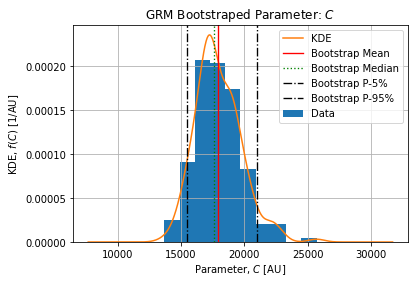

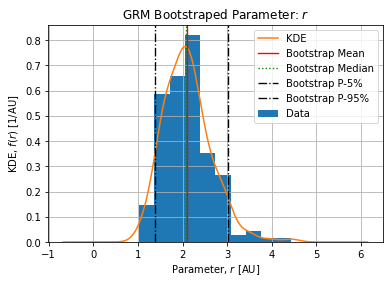

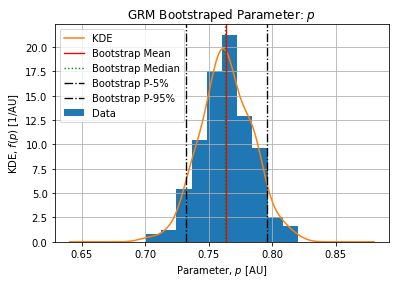

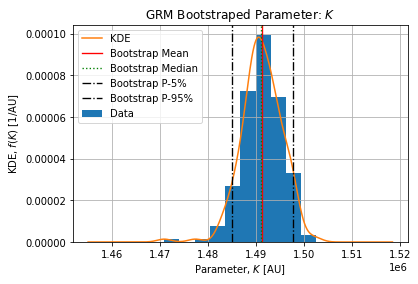

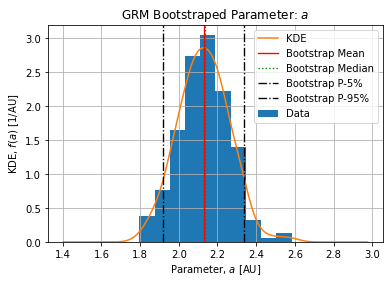

In [25]:
for i, k in enumerate(params):
    fig, axe = plt.subplots()
    sparams[k].plot(kind="hist", ax=axe, label="Data", density=1)
    sparams[k].plot(kind="kde", ax=axe, label="KDE")
    axe.axvline(sstats.loc["mean", k], linestyle="-", color="red", linewidth=1.35, label="Bootstrap Mean")
    axe.axvline(sstats.loc["50%", k], linestyle=":", color="green", linewidth=1.35, label="Bootstrap Median")
    axe.axvline(quantiles.loc[0.05, k], linestyle="-.", color="black", linewidth=1.35, label="Bootstrap P-5%")
    axe.axvline(quantiles.loc[0.95, k], linestyle="-.", color="black", linewidth=1.35, label="Bootstrap P-95%")
    #axe.axvline(popt[i], linestyle="-.", color="red", linewidth=1.35, label="Single Fit")
    axe.legend()
    axe.set_title(r"GRM Bootstraped Parameter: $%s$" % k)
    axe.set_xlabel(r"Parameter, $%s$ [AU]" % k)
    axe.set_ylabel(r"KDE, $f(%s)$ [1/AU]" % k)
    axe.grid()

Text(0, 0.5, 'Standardized Distributions')

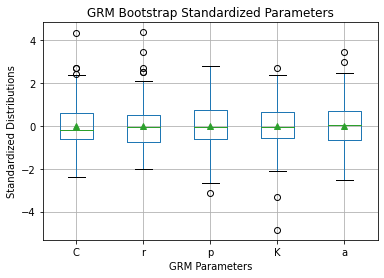

In [26]:
zP = (sparams - sstats.loc["mean",:])/sstats.loc["std",:]
axe = zP.boxplot(showmeans=True)
axe.set_title("GRM Bootstrap Standardized Parameters")
axe.set_xlabel("GRM Parameters")
axe.set_ylabel("Standardized Distributions")

In [27]:
tests = []
for k in sstats:
    p = stats.norm.fit(zP[k])
    t = stats.ks_1samp(zP[k], stats.norm().cdf)
    tests.append({
        "parameter": k,
        "loc": p[0], "scale": p[1],
        "ks": t.statistic, "p-value": t.pvalue
    })
tests = pd.DataFrame(tests)

In [28]:
#print(
tests.set_index("parameter")#.to_html())

,loc,scale,ks,p-value
parameter,,,,
C,1.296740e-15,0.997497,0.080350,0.143109
r,8.659740e-17,0.997497,0.065699,0.338981
p,-1.110223e-15,0.997497,0.039186,0.906524
K,2.784439e-15,0.997497,0.047484,0.739512
a,-5.817569e-16,0.997497,0.030478,0.989722


In [29]:
from sklearn import metrics

In [30]:
yhatSG = GRM(peak["index_origin"].values, 17951.709434, 2.109440, 0.763941, 1.491274e+06, 2.129987)
yhatRaw = GRM(peak["index_origin"].values, 17311.803293, 2.238137, 0.760107, 1.489341e+06, 2.144541)
yhatMV = GRM(peak["index_origin"].values, 17123.970867, 4.505620, 0.701244, 1.501879e+06, 2.150707)

In [31]:
print(
metrics.mean_squared_error(peak["cumsum_origin"], yhatRaw),
metrics.mean_squared_error(peak["cumsum_origin"], yhatSG),
metrics.mean_squared_error(peak["cumsum_origin"], yhatMV)
)

802520284645.9814 800548342950.9333 812020317025.3058


In [32]:
# Savgol: 800548342950.9333

In [33]:
sstats

,C,r,p,K,a
count,200.000000,200.000000,200.000000,2.000000e+02,200.000000
mean,17951.709434,2.109440,0.763941,1.491274e+06,2.129987
std,1801.121558,0.534494,0.020363,4.192278e+03,0.131553
min,13676.831795,1.028284,0.700643,1.470937e+06,1.796077
25%,16817.081914,1.711702,0.751492,1.488802e+06,2.042899
50%,17629.907849,2.071898,0.763188,1.491130e+06,2.133465
75%,18997.914543,2.375822,0.779201,1.493932e+06,2.219590
max,25707.487672,4.440710,0.820486,1.502641e+06,2.582613


In [38]:
sstats

,C,r,p,K,a
count,200.000000,200.000000,200.000000,2.000000e+02,200.000000
mean,17951.709434,2.109440,0.763941,1.491274e+06,2.129987
std,1801.121558,0.534494,0.020363,4.192278e+03,0.131553
min,13676.831795,1.028284,0.700643,1.470937e+06,1.796077
25%,16817.081914,1.711702,0.751492,1.488802e+06,2.042899
50%,17629.907849,2.071898,0.763188,1.491130e+06,2.133465
75%,18997.914543,2.375822,0.779201,1.493932e+06,2.219590
max,25707.487672,4.440710,0.820486,1.502641e+06,2.582613


In [37]:
sstats.loc["std",:]*1.96

C    3530.198255
r       1.047608
p       0.039911
K    8216.864590
a       0.257845
Name: std, dtype: float64

In [34]:
sstats.loc["mean",:] - sstats.loc["std",:]*1.96

C    1.442151e+04
r    1.061832e+00
p    7.240298e-01
K    1.483057e+06
a    1.872142e+00
dtype: float64

In [35]:
sstats.loc["mean",:] + sstats.loc["std",:]*1.96

C    2.148191e+04
r    3.157047e+00
p    8.038520e-01
K    1.499491e+06
a    2.387832e+00
dtype: float64

In [36]:
peak

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,index_origin,cumsum_origin,cs_mv14d_origin,cs_savgol_origin
date,,,,,,,,,,,
2021-12-21,7373,660,2027483,2.031396e+06,7440.142857,2.026398e+06,6195.411292,0,0,0.000000e+00,0.000000e+00
2021-12-22,7389,661,2034872,2.039248e+06,7851.785714,2.033237e+06,6838.237395,1,7389,7.851786e+03,6.838237e+03
2021-12-23,7524,662,2042396,2.047667e+06,8419.714286,2.040248e+06,7010.828522,2,14913,1.627150e+04,1.384907e+04
2021-12-24,6519,663,2048915,2.056412e+06,8744.357143,2.047620e+06,7372.731221,3,21432,2.501586e+04,2.122180e+04
2021-12-25,2818,664,2051733,2.065107e+06,8695.571429,2.055141e+06,7520.917319,4,24250,3.371143e+04,2.874271e+04
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-16,10609,717,3489434,3.487606e+06,9110.928571,3.487757e+06,8961.997240,57,1461951,1.456211e+06,1.461358e+06
2022-02-17,9277,718,3498711,3.496179e+06,8572.642857,3.496107e+06,8350.680972,58,1471228,1.464783e+06,1.469709e+06
2022-02-18,7717,719,3506428,3.504297e+06,8118.285714,3.504105e+06,7998.074119,59,1478945,1.472901e+06,1.477707e+06
